In [1]:
using Pkg
Pkg.activate("..")

using Distributions, LinearAlgebra, MiCRM, EasyFit, Distances, StatsBase
using OrdinaryDiffEq, DiffEqCallbacks
using CairoMakie, Colors, ColorSchemes
using JLD2
using Optim, ForwardDiff

  Activating project at `~/Projects/Working/ErCite/chemicalstressors`


In [2]:
Pkg.status()

Status `~/Projects/Working/ErCite/chemicalstressors/Project.toml`
⌃ [13f3f980] CairoMakie v0.9.2
  [35d6a980] ColorSchemes v3.19.0
  [5ae59095] Colors v0.12.8
  [459566f4] DiffEqCallbacks v2.24.3
  [b4f34e82] Distances v0.10.7
⌃ [31c24e10] Distributions v0.25.77
  [fde71243] EasyFit v0.5.7
  [f6369f11] ForwardDiff v0.10.33
  [033835bb] JLD2 v0.4.28
  [20f20a25] MakieCore v0.5.2
  [a39c0ef7] MiCRM v0.0.2 `~/Julia/Packages/MiCRM`
⌃ [429524aa] Optim v1.7.3
  [1dea7af3] OrdinaryDiffEq v6.31.2
  [2913bbd2] StatsBase v0.33.21
  [0c5d862f] Symbolics v4.13.0
Info Packages marked with ⌃ have new versions available


# Introduction

In this notebook I do some exploratory analysis of a model in which stressors are linked to consumer dynamics by uptake. This uptake has negative consequences for consumers and removes the resources from the environment. 

The basic model is as follows:
\begin{align}
    \frac{dC}{dt} &= C_i \left(\sum_{\alpha} R_{\alpha} u_{i \alpha} \gamma_{\alpha}(1 - \lambda) - m_i\right)\\
    \frac{dR}{dt} &= \rho_\alpha - R_{\alpha} \omega_\alpha - \sum_{i} C_i  R_{\alpha} u_{i \alpha} + \sum_{\beta} R_{\beta} \sum_{i} C_i u_{i \beta} l_{\beta \alpha}
\end{align}

Or in a diagram:

<center>
<img src="figs/StressorDiagram.png" width="400">
</center>

Consumers uptake and leak resources as normal. The stressor acts as a resource but has a negative effect on growth of consumer populations. 

## Code

  0.997811 seconds (479.93 k allocations: 54.008 MiB, 75.61% compilation time: 100% of which was recompilation)
  0.320794 seconds (47.36 k allocations: 2.784 MiB, 28.95% compilation time: 100% of which was recompilation)


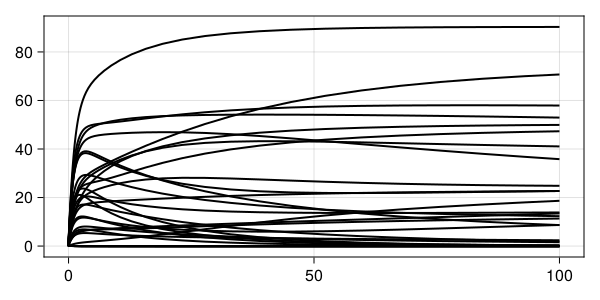

In [153]:
#solve system with stressor
#derivatives
function growth_MiCRM_detox!(dx,x,p,t,i)
    #mortality
    dx[i] += -p.m[i] * x[i]
    #resource uptake
    for α = 1:p.M
        tmp = 0.0
        for β = 1:p.M
            tmp += p.l[α,β]
        end
        dx[i] += x[α + p.N] * x[i] * p.u[i,α] * (1 - tmp) * p.kw.γ[i,α]
    end
end

#derivative function
dx!(dx,x,p,t) = MiCRM.Simulations.dx!(dx,x,p,t;  growth! = growth_MiCRM_detox!)


#params
function fu(N,M,kw)
    u = zeros(N,M)
    u[:, 1 : (M-1)] .= MiCRM.Parameters.modular_uptake(N,M - 1, N_modules = 5, s_ratio = kw[:u_ratio]) * kw[:u_tot]
    u[:, end] .= ones(N)
    return(u)
end

function fl(N,M,kw)
    l = MiCRM.Parameters.modular_leakage(M; N_modules = 5, s_ratio = kw[:l_ratio], λ = kw[:λ])
    #dont leak to or from stressor
    l[:,end] .= 0.0
    l[end,:] .= 0.0
    [l[i,:] .=  kw[:λ] * l[i,:] ./ sum(l[i,:]) for i = 1:(M-1)]
    return(l)
end

fρ(N,M,kw) = ones(M) * M 


N,M = 25,25

#gamma
γ = ones(N,M)
γ[:,end] .= 1.0

#generate test parameters
p = MiCRM.Parameters.generate_params(N, M, f_u = fu, f_l = fl, f_ρ = fρ, λ = 0.1, γ = γ, u_ratio = 100.0, l_ratio = 10.0, u_tot = 100.0)
p.ρ .= M
p.ρ[end] = 10.0

#simualtion params
x0 = rand(N+M)
t = (0.0,1e2)

prob = ODEProblem(dx!, x0, t, p)

@time sol1 = solve(prob, AutoTsit5(Rosenbrock23()));
@time sol2 = solve(prob, AutoTsit5(Rosenbrock23()), callback = TerminateSteadyState());

plot_sol(sol,ax) = Makie.series!(ax, sol.t, sol[:,:], solid_color = "black")


f = Figure(resolution = (600,300))
ax = Axis(f[1,1])
plot_sol(sol1,ax)
f

# Simulation details

## Measuring responses

we consider three aspects of the stress response over different timescales. 

1. Degree of amplification of a pulse of chemical stressor
2. The rate of return after a pulse of chemical stressor
3. The change in equilbirium state following chronic exposure to the stressor. 

<img src="figs/pulse.png" width="400">


## Interactions

We consider how these responses are modified by the community context and how interactions between consumer populations affect the response. 

* cooperation increases robustness? (Oña 2022)

* competition increases sensitvtiy (Violle et al. 2010)


### Resource Specialisation $s$
the degree to which consumers tend to specialise on their own resources

<center>
<img src="figs/Uptake_spec.png" width="400">
</center>

In [4]:
f = Figure(resolution = (600,300))

ax1 = Axis(f[1,1],title = "Low Specialisation")
ax2 = Axis(f[1,2],title = "High Specialisation")

heatmap!(ax1, fu(50,26,Dict(:u_ratio => 1.0)), colorrange = (0.0,1.0))
heatmap!(ax2, fu(50,26,Dict(:u_ratio => 100.0)), colorrange = (0.0,1.0))

f

LoadError: KeyError: key :u_tot not found

### Leakage $\lambda$
The amount of resources leaked as metabolic by-products

<center>
<img src="figs/Leakage.png" width="400">
</center>

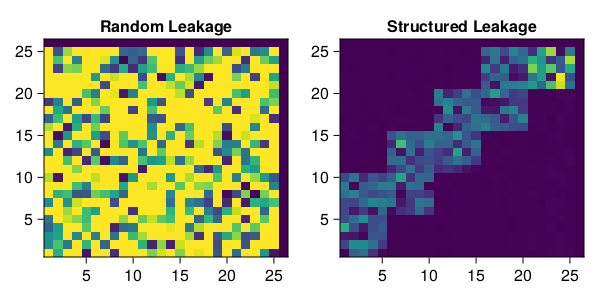

In [5]:
f = Figure(resolution = (600,300))

ax1 = Axis(f[1,1],title = "Random Leakage")
ax2 = Axis(f[1,2],title = "Structured Leakage")

heatmap!(ax1, fl(50,26,Dict(:l_ratio => 1.0, :λ => 0.5)), colorrange = (0.0,0.5 / 26))
heatmap!(ax2, fl(50,26,Dict(:l_ratio => 100.0, :λ => 0.5)), colorrange = (0.0,5 / 26))

f

In [163]:
r = JLD2.load("../data/detox_simulations.jld2")
analysis = JLD2.load("../data/analysis.jld2")

N_r,N_u, N_l, N_λ, N_ρ, N_utot = size(r["J"])

s_vec = 10 .^ range(0, 2, length = 20)
ρ_vec = ρ_vec = [0.0, 0.01, 0.1, 1.0]
λ_vec = [0.1, 0.3, 0.7]

mean_no_diag(A) = (sum(A) - sum(A[diagind(A)])) / (prod(size(A) .- [0, 1]))

mean_no_diag (generic function with 1 method)

In [164]:
function proportion_pos(A)
    n_pos = sum(A .> 0.0) - size(A)[1]
    n_neg = sum(A .< 0.0)
    return(n_pos / (n_pos + n_neg))
end

function sum_neg(A)
    sum(A[A .< 0.0])
end

function sum_pos(A)
    sum(A[A .> 0.0]) - size(A)[1]
end

a_mean = mean_no_diag.(analysis["a_mat"])
prop_pos = proportion_pos.(analysis["a_mat"]);
sum_neg_ = sum_neg.(analysis["a_mat"])
sum_pos_ = sum_pos.(analysis["a_mat"]);

# Return Time

The longterm response is determined by the structure of the community and is independet of the perturbation. Thus it is unlikely that the 

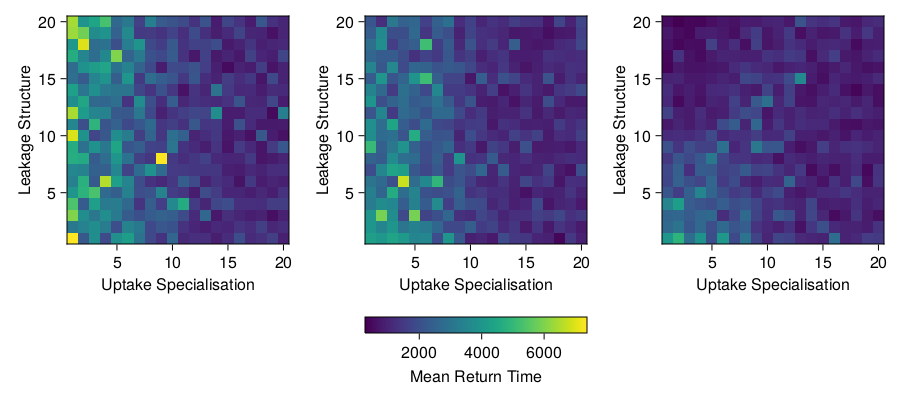

In [203]:
lims = -1 ./ extrema(mean(Real.(analysis["Rinf"]), dims = 1))

f = Figure(resolution = (900,400))

for l = 1:3
    R = 1 ./ -mean(Real.(analysis["Rinf"])[:,:,:,l,1],dims=(1))[1,:,:]
    ax = Axis(f[1,l], xlabel = "Uptake Specialisation", ylabel = "Leakage Structure")

    heatmap!(ax,R, colormap = :viridis, colorrange = lims)
end
    
Colorbar(f[2,2], colormap = :viridis, vertical = false, flipaxis = false, label = "Mean Return Time", limits = lims)

f

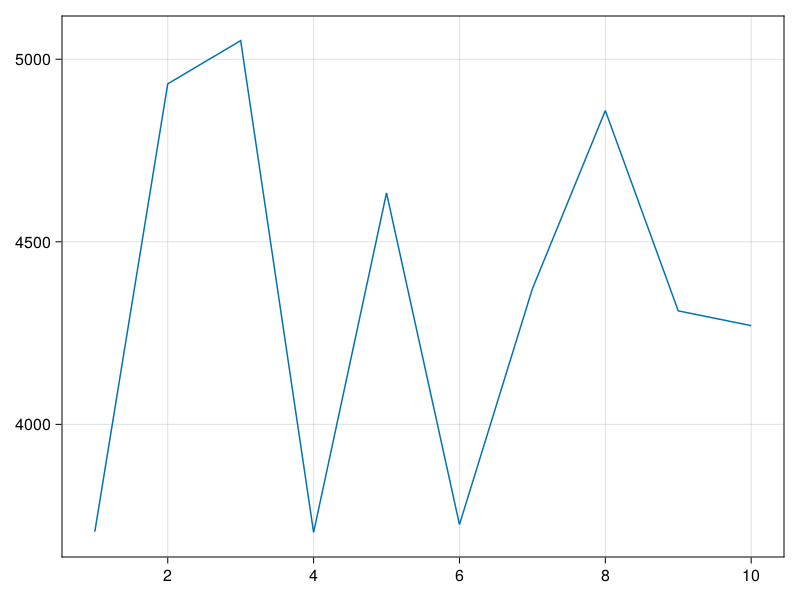

In [221]:
# plotting
R = -1 ./ mean(Real.(analysis["Rinf"])[:,1,:,1,1],dims=2)[:,1,:]
lines(R[:], solid_color = "black")

In [182]:

λ = map(x -> Real(x), analysis["Rinf"])

f = Figure(resolution = (1000,300))
ax = [Axis(f[1,i], xlabel = "Interaction Strength") for i = 1:3]
res = zeros(20,3)

ρ = 3

c = ["red","green","blue"]

# #rescale rates
for l = 1:3
    # for l_s = 1:N_l
        
        R = λ[:,:,:,l,ρ]
    
        # s = hcat(fill(s_vec, N_r)...)'
    
        # boxplot!(ax[l], log10.(s[:]), R[:], color = "grey", width = 0.1)
        
        
        # println(size(R))
        
        # a = a_mean[:,:,:,l,ρ][:]
        # bins = range(minimum(a)-0.1,maximum(a)+0.1,length = 100)
        # a_bin = map(x -> findfirst(x .< bins), a)
        # w = (bins[1:end-1] .+ bins[2:end]) ./ 2
        # indxR = findall(R .< 0)
        # boxplot!(ax[l], (w[a_bin[indxR]]), log.(-1 ./ R[indxR]), label = string(λ_vec[l]), color = (c[l],0.6), show_outliers= false, width = 0.002)
    # end
end

# axislegend.(ax, position = :lt)
# linkaxes!(ax...)

# ax[2].title = "Return Time"

# f



# s_vec

(10, 20, 20)
(10, 20, 20)
(10, 20, 20)


# Maximum perturbation

The maximum pertubations size measures the largest displacement from equilibrium. This shows a strong relationship with the interaction measure, as interactions become more competitive the size of the maximal displacement increases. This suggests that competitive communities (i.e. those with many functionally similar species who negatively effect each other) are more susceptable to chemical perturbations. 

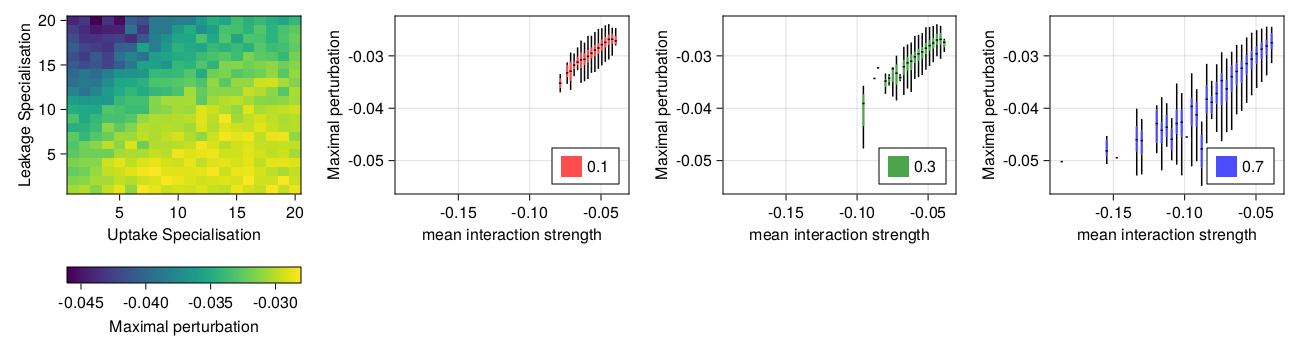

In [150]:
max_p = map(x -> x[1], analysis["max_p"])
R = mean(max_p[:,:,:,3,1],dims=(1))[1,:,:]

f = Figure(resolution = (1300,350))

ax = Axis(f[1,1], xlabel = "Uptake Specialisation", ylabel = "Leakage Specialisation")
heatmap!(ax,R, colormap = :viridis)

Colorbar(f[2,1], colormap = :viridis, vertical = false, flipaxis = false, label = "Maximal perturbation", limits = extrema(R))

ax = [Axis(f[1,i + 1], ylabel = "Maximal perturbation", xlabel = "mean interaction strength") for i = 1:3]
res = zeros(20,3)

c = ["red","green","blue"]


ρ = 1

# #rescale rates
for l = 1:3
        mp = max_p[:,:,:,l,ρ][:]
        a = a_mean[:,:,:,l,ρ][:]
    
        bins = range(minimum(a)-0.1,maximum(a)+0.1,length = 100)
        a_bin = map(x -> findfirst(x .< bins), a)
        w = (bins[1:end-1] .+ bins[2:end]) ./ 2
    
        indxR = findall(mp .== mp)
        boxplot!(ax[l], (w[a_bin[indxR]]), mp[indxR], label = string(λ_vec[l]), color = (c[l],0.7), show_outliers = false, width = 0.002)
end

axislegend.(ax, position = :rb)
linkaxes!(ax...)

f

# Press Disturbance

In [33]:
function get_uptake_flux(mass,p)
    C = mass[1:25]
    R = mass[26:end]

    up_R = zeros(25)
    # a = 25
    for a = 1:25
        for i = 1:25
            up_R[a] -= p.u[i,a] * C[i] * R[a]
            for b = 1:25
                up_R[b] += p.u[i,b] * C[i] * R[b] * p.l[b,a]
            end

        end
    end
    return(sum(up_R))
end

get_uptake_flux (generic function with 1 method)

In [121]:
get_C(mass) = sum(mass[1 : 25])
get_R(mass) = sum(mass[26 : end-1])

C_mass = get_C.(r["mass"])
R_mass = get_R.(r["mass"]);
up_flux = get_uptake_flux.(r["mass"],r["p"])

#relative mass
ΔC = zeros(N_r,N_u,N_l,N_λ, N_utot)
ΔR = zeros(N_r,N_u,N_l,N_λ, N_utot)
ΔU = zeros(N_r,N_u,N_l,N_λ, N_utot)

for rep = 1:N_r
    ΔC[rep,:,:,:,:] = C_mass[rep,:,:,:,end,:] .- C_mass[rep,:,:,:,1,:]
    ΔR[rep,:,:,:,:] = R_mass[rep,:,:,:,end,:] .- R_mass[rep,:,:,:,1,:]
    ΔU[rep,:,:,:,:] = up_flux[rep,:,:,:,end,:] .- up_flux[rep,:,:,:,1,:]
end

# Change in Biomass

In [45]:
f = Figure(resolution = (1000,400))
ax = [Axis(f[1,i]) for i = 1:3]
res = zeros(20,3)

c = ["red","green","blue"]

ρ = 1

# #rescale rates
for l = 1:3
        C = ΔC[:,:,:,l,1][:]
        a = a_mean[:,:,:,l,ρ][:]
        scatter!(ax[l], (a), (C), label = string(λ_vec[l]), color = (c[l],0.2))
end

axislegend.(ax, position = :lt)

f



LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 4000 and 1000

# Change in Resources

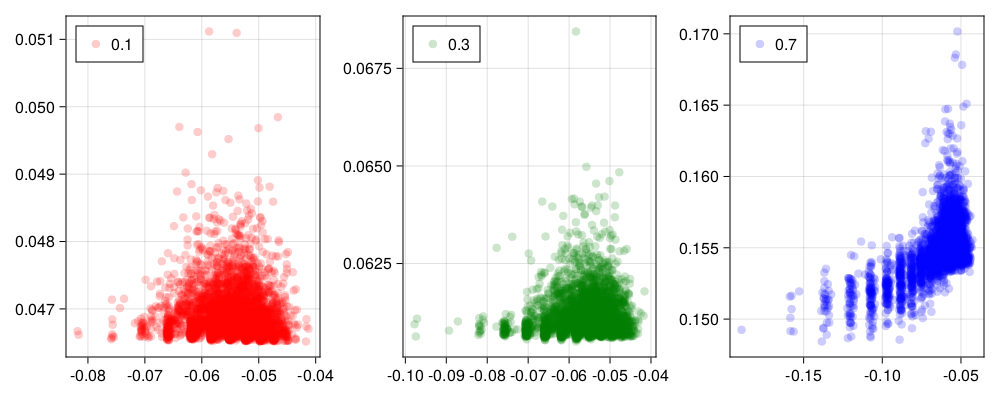

In [876]:
f = Figure(resolution = (1000,400))
ax = [Axis(f[1,i]) for i = 1:3]
res = zeros(20,3)

c = ["red","green","blue"]

ρ = 1

# #rescale rates
for l = 1:3
        R = ΔR[:,:,:,l][:]
        a = a_mean[:,:,:,l,ρ][:]
        scatter!(ax[l], (a), (R), label = string(λ_vec[l]), color = (c[l],0.2))
end

axislegend.(ax, position = :lt)

f

# Uptake Flux

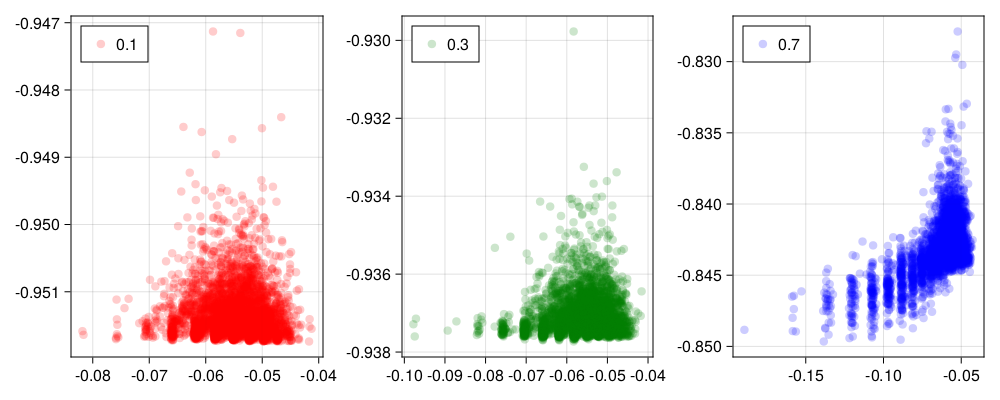

In [906]:
f = Figure(resolution = (1000,400))
ax = [Axis(f[1,i]) for i = 1:3]
res = zeros(20,3)

c = ["red","green","blue"]

ρ = 1

# #rescale rates
for l = 1:3
        Up = ΔU[:,:,:,l][:]
        a = a_mean[:,:,:,l,ρ][:]
        scatter!(ax[l], (a), (Up), label = string(λ_vec[l]), color = (c[l],0.2))
end

axislegend.(ax, position = :lt)

f

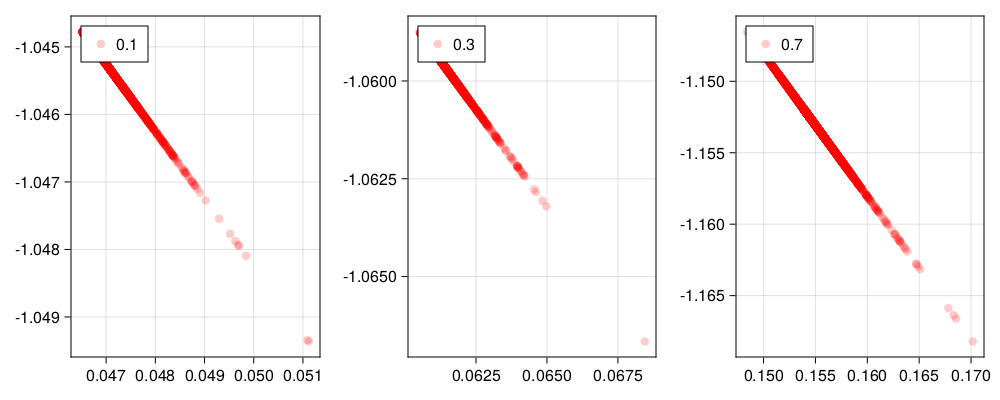

In [898]:
f = Figure(resolution = (1000,400))
ax = [Axis(f[1,i]) for i = 1:3]
res = zeros(20,3)

c = ["red","green","blue"]

ρ = 1

# #rescale rates
for l = 1:3
        max_p_ = max_p[:,:,:,l,ρ][:]

        R = ΔR[:,:,:,l][:]
        C = ΔC[:,:,:,l][:]
        a = a_mean[:,:,:,l,ρ][:]
    
        scatter!(ax[l], R , C, label = string(λ_vec[l]), color = ("red",0.2))
end

axislegend.(ax, position = :lt)

f

# approximations

\begin{align}
        R_{tot}^* &\approx \frac{\bar{m} +u_s R_s^*}{\bar{u} (1 - \lambda)} \\
        C_{tot}^* &\approx \frac{\rho_{tot} - \omega_{tot}}{(1 - \lambda) \bar{u} R_{tot}^*} = \frac{\rho_{tot} - \omega_{tot}}{\bar{m} +u_s R_s^*}
\end{align}

Adding stressor will increase resource abundance but reduce consumer biomass

\begin{align}
    u_{tot} = (1-\lambda) \sum_{i,\alpha} u_{i \alpha} C_i R_i \approx \bar{u} R_{tot} C_{tot} = \frac{\rho_{tot} - \omega_{tot}}{(1 - \lambda)}
\end{align}

In [907]:
#testing quantities
f_Rtot(p,Rs) = mean(p.m + p.u[:,end] * Rs) / (mean(p.u[:,1:24]) * (1 - p.kw.λ))
f_Ctot(p,Rs) = (sum(p.ρ) - f_Rtot(p, Rs))/((1 - p.kw.λ)*mean(p.u[:,1:24]) * f_Rtot(p,Rs))
f_Rs(p,Ctot) = p.ρ[end] / (p.ω[end] + Ctot) 

f_Rs (generic function with 1 method)

In [920]:
p_ = r["p"][1,20,20,3,end]
m_ = r["mass"][1,20,20,3,end];

In [921]:
println("resources: ", sum(m_[26:end-1]),"  ",f_Rtot(p_,m_[end]))
println("Consumers: ", sum(m_[1:25]),"  ",f_Ctot(p_,m_[end]))
println("Stressor: ",  m_[end],"  ",Rs(p_,f_Ctot(p_,m_[end])))

resources: 82.53566061939888  80.15459944801874
Consumers: 516.4662718737012  519.8408117700154
Stressor: 0.0019324931002345043  0.0019199724318868547


In [ ]:


function get_pred(p,m)
    #get simulated
    C = sum(m[1:25])
    R = sum(m[26:49])
    Rs = m[end]
    
    #get pred
    R_pred = f_Rtot(p,m[end])
    C_pred = f_Ctot(p,m[end])
    Rs_pred = m[end]
    
    return([C ./ C_pred, R ./ R_pred, Rs ./ Rs_pred])
end

function get_sim(p,m)
    #get simulated
    C = sum(m[1:25])
    R = sum(m[26:49])
    Rs = m[end]
    
    return([C, R, Rs])
end
    
results_pred = get_pred.(r["p"],r["mass"])
sim_pred = get_pred.(r["p"],r["mass"]);

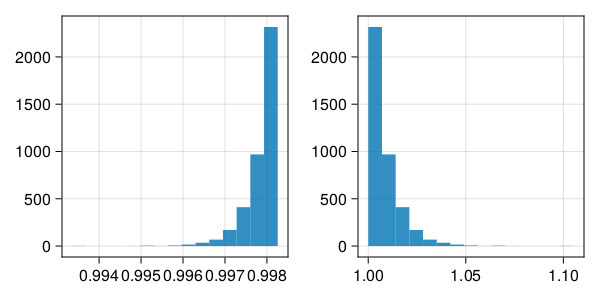

In [ ]:
x1_plt = map(x -> x[1], results_pred[:,:,:,1,4])
x2_plt = map(x -> x[2], results_pred[:,:,:,1,4])

f = Figure(resolution = (600,300))
ax1 = Axis(f[1,1])
hist!(ax1, x1_plt[:])

ax2 = Axis(f[1,2])
hist!(ax2, x2_plt[:])

f